# KNN/Decision Tree Analysis of May 2021 Divvy Data

### Import Packages and Data

In [ ]:
# import packages
import pandas as pd

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import BaggingClassifier

from sklearn.model_selection import cross_validate
import sklearn.metrics as metrics
from sklearn.feature_selection import chi2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# import data
data = pd.read_csv(r'/content/all-months-divvy-tripdata-full.csv')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (6,8) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [ ]:
membership = data['member_casual']
member_bool = np.ndarray(membership.size)
for i in range(membership.size):
    if membership[i] == 'member':
        member_bool[i] = True
    else:
        member_bool[i] = False

scaler = MinMaxScaler()

duration = data['duration']
distance = data['distance']
start_hour = data['start_hour']
end_hour = data['end_hour']
# for chi2 test we cannot have negative values so we must scale temp
temp = scaler.fit_transform(data['temp'].values.reshape(-1,1))
precip = data['precip']
humid = data['humid']
snow_depth = data['snow_depth']

In [ ]:
# one ride has a duration less than 0 so we need to fix this
for i in range(len(duration)):
  if duration[i] < 0:
    duration[i] = 0

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


### Test/Plot KNN/DT models

In [ ]:
# Grid search method that prints out the score of the best model on the testing set and returns 
from sklearn.model_selection import GridSearchCV

def grid_search(model, parameters, X_train, y_train, X_test, y_test):
  clf = GridSearchCV(model, parameters, cv=3, scoring='roc_auc')
  clf.fit(X_train, y_train)
  print("The score of this model on the data is:", clf.score(X_test, y_test), "\nwith parameters:", clf.best_params_)
  return clf

In [ ]:
# Perform feature selection and train test split
features = np.column_stack([distance, duration, start_hour, end_hour, temp, precip, humid, snow_depth])
scaled_features = scaler.fit_transform(features)
feature_names = ['distance', 'duration', 'start_hour', 'end_hour', 'temp', 'precip', 'humid', 'snow_depth']
selected_features = {}
selected_scaled_features = {}
chi2s, p_values = chi2(features, member_bool)
for i in range(len(feature_names)):
    if p_values[i] < 0.05:
        selected_features[feature_names[i]] = features[:,i]
        selected_scaled_features[feature_names[i]] = scaled_features[:,i]

selected_features = pd.DataFrame.from_dict(selected_features)
selected_scaled_features = pd.DataFrame.from_dict(selected_scaled_features)
print("The selected features are:", selected_features.columns.values)
X_train, X_test, y_train, y_test = train_test_split(selected_features, member_bool, test_size = 0.20)
s_X_train, s_X_test, s_y_train, s_y_test = train_test_split(selected_scaled_features, member_bool, test_size = 0.20)

The selected features are: ['distance' 'duration' 'start_hour' 'end_hour' 'temp' 'precip' 'humid'
 'snow_depth']


In [ ]:
# create function to plot the actual distribution of the data vs. predicted distribution
def plot_model(model, X_test, y_test):
  y_pred = model.predict(X_test)
  actual_members = 0
  predicted_members = 0
  actual_casuals = 0
  predicted_casuals = 0

  for i in range(len(y_test)):
    if y_pred[i]:
      predicted_members += 1
    else:
      predicted_casuals += 1
    if y_test[i]:
      actual_members += 1
    else:
      actual_casuals += 1

  X_axis = np.arange(2)

  plt.bar(X_axis - 0.2, [actual_members, actual_casuals], 0.4, label = 'Actual', color='deepskyblue')
  plt.bar(X_axis + 0.2, [predicted_members, predicted_casuals], 0.4, label = 'Predictions', color='darkblue')
  labels = ['Members', 'Casuals']

  plt.xticks(X_axis, labels)
  plt.ylabel("Number of People")
  plt.title("Number of Members/Casuals in Actual vs. Prediction")
  plt.legend()
  plt.show()

In [ ]:
knn_params = {}
best_knn = grid_search(KNeighborsClassifier(weights='distance', p=1, n_neighbors=19), knn_params, s_X_train, s_y_train, s_X_test, s_y_test).best_estimator_


The score of this model on the data is: 0.7621993301154156 
with parameters: {}


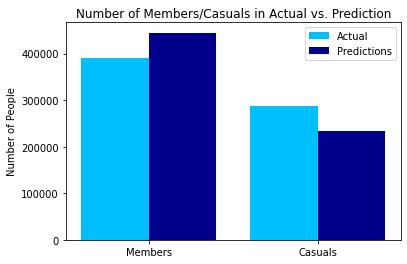

In [ ]:
plot_model(best_knn, s_X_test, s_y_test)

In [ ]:
dt_params = {}
best_dt = grid_search(DecisionTreeClassifier(criterion='entropy', min_samples_leaf=11, min_samples_split=7), dt_params, X_train, y_train, X_test, y_test).best_estimator_

The score of this model on the data is: 0.7163177356232066 
with parameters: {}


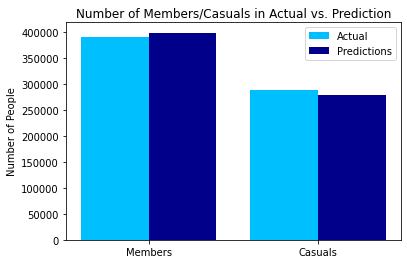

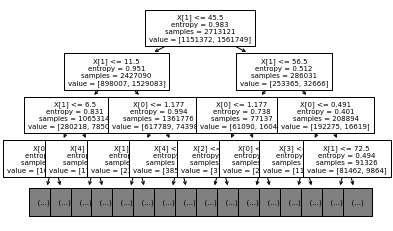

In [ ]:
plot_model(best_dt, X_test, y_test)
plot = plot_tree(best_dt, max_depth=3, fontsize=7)

Plot best decision tree

In [ ]:
# collect member and casual counts for the decision tree splits
members = [0 for i in range(8)]
casuals = [0 for i in range(8)]

for i in range(len(member_bool)):
  if selected_features['duration'][i] <= 45.5:
    if selected_features['duration'][i] <= 11.5:
      if selected_features['duration'][i] <= 6.5:
        if member_bool[i] == True:
          members[0] += 1
        else:
          casuals[0] += 1
      else:
        if member_bool[i] == True:
          members[1] += 1
        else:
          casuals[1] += 1
    else:
      if selected_features['distance'][i] <= 1.177:
        if member_bool[i] == True:
          members[2] += 1
        else:
          casuals[2] += 1
      else:
        if member_bool[i] == True:
          members[3] += 1
        else:
          casuals[3] += 1
  else:
    if selected_features['duration'][i] <= 56.5:
      if selected_features['distance'][i] <= 1.177:
        if member_bool[i] == True:
          members[4] += 1
        else:
          casuals[4] += 1
      else:
        if member_bool[i] == True:
          members[5] += 1
        else:
          casuals[5] += 1
    else:
      if selected_features['distance'][i] <= 0.491:
        if member_bool[i] == True:
          members[6] += 1
        else:
          casuals[6] += 1
      else:
        if member_bool[i] == True:
          members[7] += 1
        else:
          casuals[7] += 1

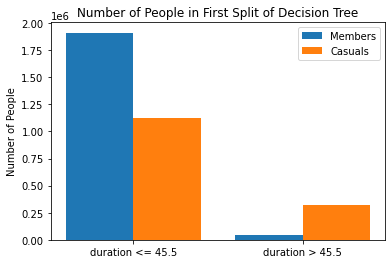

In [ ]:
# plot 1
X_axis = np.arange(2)

plt.bar(X_axis - 0.2, [members[0]+members[1]+members[2]+members[3], members[4]+members[5]+members[6]+members[7]], 0.4, label = 'Members')
plt.bar(X_axis + 0.2, [casuals[0]+casuals[1]+casuals[2]+casuals[3], casuals[4]+casuals[5]+casuals[6]+casuals[7]], 0.4, label = 'Casuals')
labels = ['duration <= 45.5', 'duration > 45.5']

plt.xticks(X_axis, labels)
plt.ylabel("Number of People")
plt.title("Number of People in First Split of Decision Tree")
plt.legend()
plt.show()

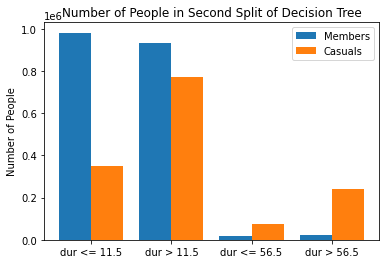

In [ ]:
# plot 2
X_axis = np.arange(4)
labels = ['dur <= 11.5', 'dur > 11.5', 'dur <= 56.5', 'dur > 56.5']

plt.bar(X_axis - 0.2, [members[0]+members[1], members[2]+members[3], members[4]+members[5], members[6]+members[7]], 0.4, label = 'Members')
plt.bar(X_axis + 0.2, [casuals[0]+casuals[1], casuals[2]+casuals[3], casuals[4]+casuals[5], casuals[6]+casuals[7]], 0.4, label = 'Casuals')

plt.xticks(X_axis, labels)
plt.ylabel("Number of People")
plt.title("Number of People in Second Split of Decision Tree")
plt.legend()
plt.show()

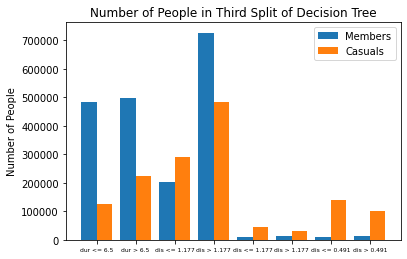

In [ ]:
# plot 3
X_axis = np.arange(8)
labels = ['dur <= 6.5', 'dur > 6.5', 'dis <= 1.177', 'dis > 1.177', 'dis <= 1.177', 'dis > 1.177', 'dis <= 0.491', 'dis > 0.491']

plt.bar(X_axis - 0.2, [members[0], members[1], members[2], members[3], members[4], members[5], members[6], members[7]], 0.4, label = 'Members')
plt.bar(X_axis + 0.2, [casuals[0], casuals[1], casuals[2], casuals[3], casuals[4], casuals[5], casuals[6], casuals[7]], 0.4, label = 'Casuals')

plt.xticks(X_axis, labels, fontsize=6)
plt.ylabel("Number of People")
plt.title("Number of People in Third Split of Decision Tree")
plt.legend()
plt.show()

Improve Decion Tree Performance with Ensemble Methods

In [ ]:
bagging_params = {}
best_bagging = grid_search(BaggingClassifier(base_estimator=best_dt, n_estimators=25), bagging_params, X_train, y_train, X_test, y_test).best_estimator_

The score of this model on the data is: 0.7719183437631145 
with parameters: {}
